#Mapping NY State: Population Density with Datashader

In this notebook, we'll use the same clean US Census population and geographic data we used in the last notebook, but instead of Kepler GL, we'll map population density using Datashader. Let's see if Datashader can help speed up our load time.

#### *Up close: data cleaning and mapping*

The notebooks below provide a detailed look at the other stages of cleaning and mapping data for this project. The final steps of creating a SQL database of indoor farms in New York City and then mapping them will follow shortly.

* [Introduction: The State of Indoor Farming in the US](00_IndoorAgriculture_start.ipynb) 
* [Data Cleanup: US Census population data](01_DataCleanup_Population.ipynb) 
* [Data Cleanup: GEOID tables](02_DataCleanup_GEOIDs.ipynb)
* [Data Cleanup: Geographic data](03_DataCleanup_GIS.ipynb)
<!-- * [Mapping NY State: Population Density](http://localhost:8888/lab/tree/notebooks/04_Mapping_Population.ipynb) -->
* SQL Database Creation: Indoor Farms - *coming soon...*
* Mapping NY State: Indoor Farms - *coming soon...*

#### *Some helper code for managing file paths*
We'll use the code below throughout this project to make it easier to refer to the folders where our various data files are stored.

In [1]:
# os and pathlib modules used to make it easier to refer to project folders 

import os, pathlib
base_dir = pathlib.Path(os.getcwd()).parent
data_archive_dir = os.path.join(base_dir, "data_archive")
clean_data_dir = os.path.join(data_archive_dir, "clean")
# data_dir = os.path.join(base_dir, "data")
# shapes_dir = os.path.join(data_dir,"shapes")
# json_dir = os.path.join(data_dir,"geojson")
# util_dir = os.path.join(data_dir,"util")

#### *Imports*

In [2]:
import geopandas as gpd
import spatialpandas as sp
from spatialpandas.io import read_parquet
import datashader as ds
import colorcet as cc
# using Colorcet colormaps are cool! more about this later...

#### *Suppress annoying warnings from Shapely*
The warnings appear when we create a Spatialpandas Geo DataFrame from a GeoPandas DataFrame.  Spatialpandas calls deprecated Shapely functions when converting Shapely geometry to Spatialpandas geometry.

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

### Load GeoParquet files for NY State census tract data and convert to Spatialpandas

(spatialpandas does not appear to suppor GeoParquet as yet)

In [4]:
ny_tracts_parquet = os.path.join(clean_data_dir,'tl_2020_36_tract20.parquet')

df_ny_tracts = gpd.read_parquet(ny_tracts_parquet)

df_ny_tracts = sp.GeoDataFrame(df_ny_tracts)

df_ny_tracts.head(3)

,State FIPS,County FIPS,Census Tract Name,GEOID Census Tract,Population,Land Area,Water Area,Population Density,geometry
0,36,47,"Census Tract 7, Kings County, New York",36047000700,4415,176774,0,64686,"MultiPolygon([[[-74.001542, 40.692786, -74.001..."
1,36,47,"Census Tract 9, Kings County, New York",36047000900,5167,163469,0,81865,"MultiPolygon([[[-73.994046, 40.690897, -73.994..."
2,36,47,"Census Tract 11, Kings County, New York",36047001100,1578,168507,0,24254,"MultiPolygon([[[-73.99072799999999, 40.693048,..."


### Load GeoParquet files for NYC census tracts and convert to Spatialpandas

In [5]:
nyc_outline_parquet = os.path.join(clean_data_dir,'geodf_place_nyc.parquet')

df_nyc_outline = gpd.read_parquet(nyc_outline_parquet)

df_nyc_outline = sp.GeoDataFrame(df_nyc_outline)

df_nyc_outline.head(3)

,State Name,State,State FIPS,Place,Place FIPS,County,Land Area,Water Area,geometry
0,New York,NY,36,New York City,51000,"Bronx County, Kings County, New York County, Q...",778165283,445421632,"MultiPolygon([[[-74.040747, 40.700167, -74.040..."


### Calculate lattitude and longitude bounds
We're going to use Datashader to create two images, then stack one on top of the other:
1. NY State Census Tracts shaded by Population Density
1. Boundary of NYC outlined

Given that the geometry for these two images have different bounds (NY State is a much larger lattitued/longitude space than NYC) - we need to explicitly set the bounds (min and max lattitude and longitude) to avoid the below error.

<div style="font-size: .7rem; padding: .5rem .7rem .5rem .7rem; background-color: rgb(64,32,32); border: 1px solid rgb(64,64,64); border-radius: 1rem;">
Error generated when we try to stack two images without setting x_range and y_range when we create
a canvas:
   
<pre style="padding: .5rem .5rem .5rem .5rem;">
TypeError: ufunc 'over' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
<pre>
</div>


In [6]:
a = df_ny_tracts['geometry'].total_bounds
b = df_nyc_outline['geometry'].total_bounds

x_range = ( min( a[0], b[0]), max( a[2], b[2]) )
y_range = ( min( a[1], b[1]), max( a[3], b[3]) )

#### Set plot height and colors

In [7]:
plot_height = 600

# nyc_tracts_colors = cc.glasbey_warm
ny_tracts_colors = cc.fire

nyc_border_color = (64, 212, 64) # lime green
nyc_border_width = 2

canvas = ds.Canvas( plot_height=plot_height, x_range=x_range, y_range=y_range )
#canvas = ds.Canvas( plot_height=plot_height )

#### Create the map image

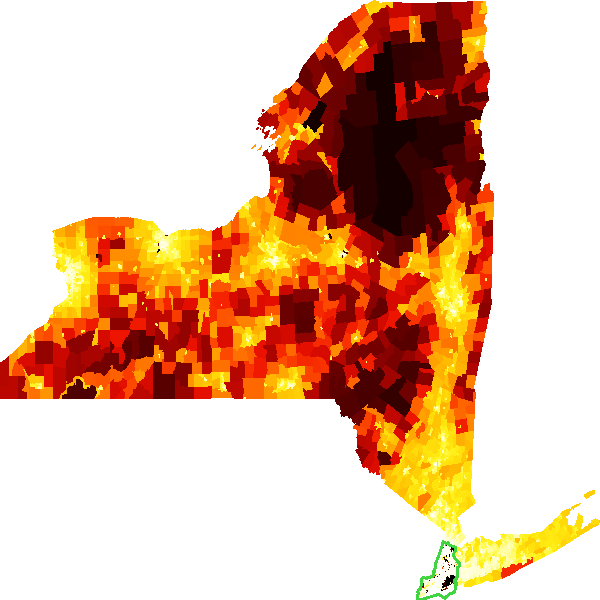

In [8]:
# Aggregate polygons from df_ny_tracts using Population Density as the data for shading
agg_ny_tracts = canvas.polygons(df_ny_tracts, geometry='geometry', agg=ds.mean('Population Density') )

# Create an image by shading the aggregated polygons according to 
# the Population Density values using the colors set above
# img_ny_tracts = ds.transfer_functions.shade(agg_ny_tracts, cmap=nyc_tracts_colors)
img_ny_tracts = ds.transfer_functions.shade(agg_ny_tracts, cmap=ny_tracts_colors)

# Create another image by drawing a line along the boundary of NYC
agg_nyc_outline = canvas.line(df_nyc_outline, geometry='geometry', agg=ds.any(), line_width=nyc_border_width)
img_nyc_outline = ds.transfer_functions.shade(agg_nyc_outline, cmap=[nyc_border_color]);

# stack the images on top of each other
ds.tf.stack(img_ny_tracts, img_nyc_outline)